<a href="https://colab.research.google.com/github/FMagnani/MeanFieldKuramotoModel/blob/main/KuramotoModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting


In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd

In [2]:

class Integrator():
    
    def __init__(self, init_distribution, frequencies, coupling, temperature):
        

        if not (len(init_distribution) == len(frequencies)):
            raise ValueError("init_distribution and frequencies should have same length")
        
        self.N = np.array(init_distribution).shape[0]
        self.phi = np.array(init_distribution)
        self.freqs = np.array(frequencies)
        self.T = temperature
        self.k = coupling
        self.coherence, self.psi = self.get_orderPars()
        
        self.scheme_dict = {
                            'euler': self.Euler,
                            'heun': self.Heun,
                            'taylor': self.Taylor
                            }
        
        
    def get_orderPars(self):
        """
        psi: mean phase
            psi = 1/N Sum_j phi_j
        
        r: coherence
            Amplitude (length) of the center-of-mass vector
            r = SQRT[ (1/N Sum_j cos(phi_j))^2 + (1/N Sum_j sin(phi_j))^2 ]
        """
        psi = np.mean(self.phi)
        
        cosines = np.cos(self.phi)
        sines = np.sin(self.phi)
        mean_cos = np.mean(cosines)
        mean_sin = np.mean(sines)
        coherence = np.sqrt( mean_cos**2 + mean_sin**2 )

        return coherence, psi


    def integrate(self, Dt, iterations, numerical_scheme, seed):
        """
        

        Parameters
        ----------
        Dt : float
            Time interval for integration.
        iterations : int
            Total number of iterations.
        numerical_scheme : str
            One of: 
                'euler'
                'heun'
        seed : int
            Seed for generation of random numbers for the Wiener process.

        Returns
        -------
        phi_history : np.array with shape (len(phi), iterations)
            Phase of each oscillator at each iteration.
        coherence_history : np.array with shape (len(phi))
            The coherence parameter at each iteration.
        psi_history : np.array with shape (len(phi))
            The mean phase at each iteration.
        """
                
        scheme = self.scheme_dict[numerical_scheme]
        
        coherence_history = np.array([self.coherence])
        psi_history = np.array([self.psi])
    
        # The square brackets inside are needed
        phi_history = np.array([self.phi])

        N = self.N


        ## TODO
        ## Update the following description
        
        ## The noise realizations must be created for all the iterations 
        ## before the loop. If we create a single one at each loop iteration,
        ## since the seed has been chosen, they will be all equal.
        ## Furthermore, some schemes as the Taylor scheme needs two random
        ## variables correlated. They are created via a multivariate gaussian
        ## distribution. 
        ## Later in the scheme function, Euler and Heun methods will employ
        ## only the Wiener part (the firs of the two correlated variables)
        ## while Taylor both.
        
        means = [0,0]
        covs = [[np.sqrt(Dt),     0.5*(Dt**2)],
                [0.5*(Dt**2),     (Dt**3)/3  ]]
        noise_vars = [np.random.multivariate_normal(means, covs, N) for i in range(iterations)]
            
        for i in range(iterations):

            noise = noise_vars[i]
            
            self.phi = scheme(Dt, noise)
            
            # Pay attention to the following AWFUL syntax. It's not obvious.
            phi_history = np.append(phi_history, [self.phi], axis=0)
            
            r, psi = self.get_orderPars()
            coherence_history = np.append(coherence_history, r)
            psi_history = np.append(psi_history, psi)
         
        # phi_history = np.mod(phi_history, 2*np.pi)
        # coherence_history = np.mod(coherence_history, 2*np.pi)
        # psi_history = np.mod(psi_history, 2*np.pi)
        
        return phi_history, coherence_history, psi_history

    
    # NUMERICAL SCHEMES
    
    def speed(self, phi):
        
        # Compute all combinations between phi's entries
        xx, yy = np.meshgrid(phi,phi)        
    
        # Apply all pairwise differences in parallel
        distances = xx - yy
    
        # Apply sine to all the differences in parallel
        sines = np.sin(distances)
                
        # Forcing term
        forcings = self.k*np.mean(sines, axis=1)
    
        return self.freqs + forcings

    
    def Euler(self, Dt, noise):
        
        # Noise comes with Wiener part + first order. 
        # Only Wiener part is used here.
        # noise is a vector with a different perturbation for each oscillator.
        wiener = noise[:,0]
        
        speed = self.speed(self.phi)
        
        new_phi = self.phi + Dt*speed + self.T*wiener
        
        return new_phi


    def Heun(self, Dt, noise):

        # Noise comes with Wiener part + first order. 
        # Only Wiener part is used here.
        # noise is a vector with a different perturbation for each oscillator.
        wiener = noise[:,0]
        
        middle_pnt = self.Euler(Dt, noise)
        
        # Deterministic part
        deterministic_part = (self.speed(self.phi) + self.speed(middle_pnt))*.5

        new_phi = self.phi + Dt*deterministic_part + self.T*wiener
        
        return new_phi
        
    
    ## TODO
    ## Assess if Taylor method is right
    
    def speed_prime(self, phi):
        
        # Compute all combinations between phi's entries
        xx, yy = np.meshgrid(phi,phi)        
    
        # Apply all pairwise differences in parallel
        distances = xx - yy
    
        # Apply sine to all the differences in parallel
        cosines = np.cos(distances)
                
        # Forcing term
        forcings = -self.k*np.mean(cosines, axis=1)
    
        return forcings    
    
    
    def Taylor(self, Dt, noise):
        
        noise = np.array(noise)
        
        DW = noise[:,0]
        DZ = noise[:,1]

        f = self.speed(self.phi)
        f_prime = self.speed_prime(self.phi)
        
        new_phi = self.phi + f*Dt + self.T*DW +\
                  0.5*Dt*Dt*f*( f_prime + 0.5*self.T*self.T ) +\
                  self.T*f_prime*DZ

        return new_phi



# Figure 1

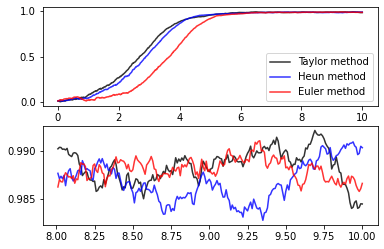

In [ ]:

"""
FIGURE 1

Comparison betweeen schemes.
"""

N = 100 # Number of oscillators

init_phi = np.linspace(0,2*np.pi,N) # Uniform
#init_phi = np.random.normal(np.pi, 1, N) # Gaussian around pi
#init_phi = np.zeros(N)

#freqs = np.random.standard_cauchy(N) # g(omega) == cauchy with gamma=1
freqs = np.zeros(N)

T = 0.1
K = 2
system = Integrator(init_phi, freqs, K, T)

iterations = 1000
Dt = 0.01
seed = 1234

_, r_taylor, _ = system.integrate(Dt, iterations, 'taylor', seed)
system = Integrator(init_phi, freqs, K, T)
_, r_heun, _ = system.integrate(Dt, iterations, 'heun', seed)
system = Integrator(init_phi, freqs, K, T)
_, r_euler, _ = system.integrate(Dt, iterations, 'euler', seed)


time_axis = Dt*np.array(range(iterations+1))

fig, (ax1,ax2) = plt.subplots(2,1)

ax1.plot(time_axis, r_taylor, 'k', label="Taylor method", alpha=.8)
ax1.plot(time_axis, r_heun, 'b', label="Heun method", alpha=.8)
ax1.plot(time_axis, r_euler, 'r', label="Euler method", alpha=.8)
ax1.legend()

ax2.plot(time_axis[-200:], r_taylor[-200:], 'k', label="Taylor method", alpha=.8)
ax2.plot(time_axis[-200:], r_heun[-200:], 'b', label="Heun method", alpha=.8)
ax2.plot(time_axis[-200:], r_euler[-200:], 'r', label="Euler method", alpha=.8)
#ax2.legend()

plt.show()

data = pd.DataFrame()
data["taylor"] = r_taylor
data["heun"] = r_heun
data["euler"] = r_euler

name = "data_"+str(N)+"particles.csv"
data.to_csv(name)



# Figure 2

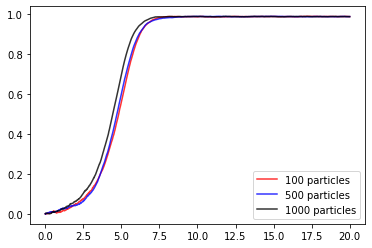

In [ ]:

"""
FIGURE 2

Comparison betweeen population number, using Taylor 3/2.
"""

N_list = [100, 500, 1000] # Number of oscillators

init_phi = np.linspace(0,2*np.pi,N) # Uniform
#init_phi = np.random.normal(np.pi, 1, N) # Gaussian around pi
#init_phi = np.zeros(N)

#freqs = np.random.standard_cauchy(N) # g(omega) == cauchy with gamma=1
freqs = np.zeros(N)

T = 0.1
K = 2

iterations = 2000
Dt = 0.01
seed = 1234

data = pd.DataFrame()

for N in N_list:
  system = Integrator(init_phi, freqs, K, T)
  _, r_taylor, _ = system.integrate(Dt, iterations, 'taylor', seed)
  data[str(N)] = r_taylor



time_axis = Dt*np.array(range(iterations+1))

fig, ax = plt.subplots()

colors = ['r', 'b', 'k']

for i in range(3):
  N = N_list[i]
  c = colors[i]
  ax.plot(time_axis, data[str(N)], color=c, label=str(N)+" particles", alpha=.8)

ax.legend()
plt.show()

name = "data.csv"
data.to_csv(name)



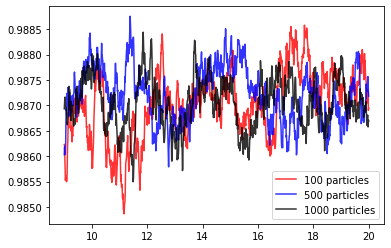

In [ ]:
fig, ax = plt.subplots()

for i in range(3):
  N = N_list[i]
  c = colors[i]
  ax.plot(time_axis[900:], data[str(N)][900:], color=c, label=str(N)+" particles", alpha=.8)

ax.legend()
plt.show()

# Figure 3


In [ ]:
"""
Figure 3

Numerically check how the presence of noise affects the critical value of the coupling.
Average value of r after stabilization is plot versus the coupling value, for three amplitudes of the noise.
"""

In [54]:

N = 500 # Number of oscillators

init_phi = np.linspace(0,2*np.pi,N) # Uniform
#init_phi = np.random.normal(np.pi, 1, N) # Gaussian around pi
#init_phi = np.zeros(N)

#freqs = np.random.standard_cauchy(N) # g(omega) == cauchy with gamma=1
freqs = np.zeros(N)

temperatures = [0, 0.25, 0.5]

iterations = 2000
Dt = 0.01
seed = 1234

data = []

for T in temperatures:
  for k in np.linspace(0,10,11):
    system = Integrator(init_phi, freqs, k, T)
    _, r, _ = system.integrate(Dt, iterations, 'taylor', seed)
    data.append((k, r[-100:].mean(), T))


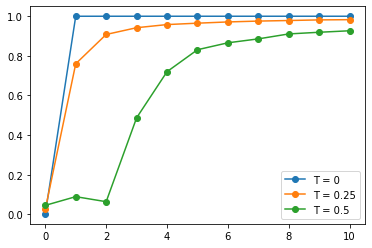

In [56]:

df = pd.DataFrame(np.array(data))
df.columns = ["k","avg_r","T"]
df.to_csv("Figure3.csv")

k_values_1 = np.array(data)[:11,0]
r_values_1 = np.array(data)[:11,1]
k_values_2 = np.array(data)[11:22,0]
r_values_2 = np.array(data)[11:22,1]
k_values_3 = np.array(data)[22:,0]
r_values_3 = np.array(data)[22:,1]

fig, ax = plt.subplots()

ax.plot(k_values_1, r_values_1, marker='o', label="T = 0")
ax.plot(k_values_2, r_values_2, marker='o', label="T = 0.25")
ax.plot(k_values_3, r_values_3, marker='o', label="T = 0.5")
ax.legend()

plt.show()


# Figure 4

In [88]:
N = 1000 # Number of oscillators

init_phi = np.linspace(0,2*np.pi,N) # Uniform
#init_phi = np.random.normal(np.pi, 1, N) # Gaussian around pi
#init_phi = np.zeros(N)

#freqs = np.random.standard_cauchy(N) # g(omega) == cauchy with gamma=1
freqs = np.ones(N)

temperatures = [0, 0.3, 0.4, 0.5]
k = 2

iterations = 1500
Dt = 0.01
seed = 1234

data = pd.DataFrame()

for T in temperatures:
  system = Integrator(init_phi, freqs, k, T)
  _, r, psi = system.integrate(Dt, iterations, 'taylor', seed)
  data["r_"+str(T)] = r
  data["psi_"+str(T)] = psi

data.to_csv("Figure4.csv")


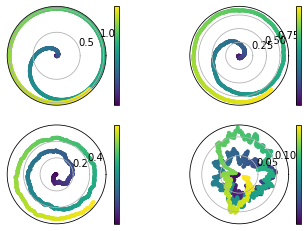

In [89]:
fig = plt.figure()

axes = []
for i in [1,2,3,4]:
  T = temperatures[i-1]

  ax = fig.add_subplot(2,2,i, projection='polar')
  axes.append(ax)

  r = np.array(data["r_"+str(T)])
  psi = np.array(data["psi_"+str(T)])

  plot_ax = ax.scatter(psi, r, c=psi, cmap='viridis', s=8)
  #ax.plot(psi[0], r[0], 'ro')   # Dot = Start   * --> o
  #ax.plot(psi[-1], r[-1], 'r*') # Star = End    * --> o
  ax.grid(True)
  ax.get_xaxis().set_ticks([])

  cbar = fig.colorbar(plot_ax)
  cbar.set_ticks([])

plt.show()

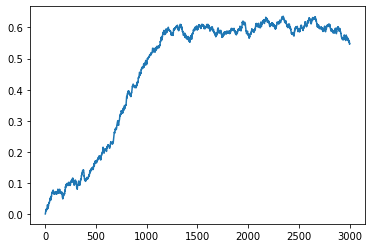

In [91]:
system = Integrator(init_phi, freqs, k, 0.4)
_, r_04, psi_04 = system.integrate(Dt, 3000, 'taylor', seed)

plt.plot(r_04)
plt.show()